# Exemplo 2 - OHS

## Encontrando soluções numéricas para equações diferenciais 

Neste notebook vamos estudar como podemos aplicar redes neurais profundas para reproduzir o comportamento de funções conhecidas. E para o treinamento usaremos uma loss function que é exatamente a equação diferencia (e não uma comparação com dados existentes). Este método tem usualmente o nome de PINN (*Physics Inspired Neural Networks*). Assim, a rede neural em si é treinada para ser uma função que se comporta como a solução da equação diferencial. 

Importando bibliotecas para visualização, cálculos numéricos e redes neurais.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as tc

from torch import nn

Declarando nossa rede em PyTorch

In [2]:
class SineActivation(nn.Module):
    """
    SineActivation: É um módulo que herda de nn.Module, criando uma função de ativação personalizadabaseada na função seno do PyTorch (tc.sin). 
    Quando aplicada em um tensor, essa função retorna o seno de cada elemento do tensor.
    """
    def __init__(self): 
        super(SineActivation, self).__init__() 
    def forward(self, x):
        return tc.sin(x)
    
class Rede_Neural(nn.Module):

    def __init__(self, neuronio, M, output=1, activation=None):
        """
        Atributos:
            neuronio: Define o número de neurônios em cada camada oculta.
            M: Número de camadas ocultas.
            output: Número de neurônios na camada de saída.
            activation: A função de ativação para as camadas ocultas.
        """
        super().__init__()
        self.neuronio = neuronio
        self.M = M
        self.output = output

        # Lista para armazenar as camadas lineares
        self.hidden_layers = nn.ModuleList([nn.Linear(1, neuronio)])
        self.hidden_layers.extend([nn.Linear(neuronio, neuronio) for _ in range(M-1)])
        
        # Última camada linear
        self.output_layer = nn.Linear(neuronio, output)

        # Função de ativação
        self.activation = activation

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        return x


Estrutura da rede:

Inicia com uma camada linear que transforma a entrada para a dimensão `neuronio`.
Adiciona M-1 camadas ocultas, todas com dimensão `neuronio`.
Termina com uma camada de saída linear que transforma a última camada oculta para a dimensão de saída definida.


Método forward:

Processa os dados de entrada através das camadas ocultas, aplicando a função de ativação especificada após cada camada linear, exceto na camada de saída, onde apenas aplica a transformação linear.
Se `creat_graph` abaixo for `True`, um parâmetro adicional acceleration é adicionado como um atributo treinável da classe, que pode ser usado para ajustar a resposta do modelo durante o treinamento.

# Oscilador harmonico Simples

$$

\frac{{d^2\theta}}{{dt^2}} + \omega_0^2 \theta =0

$$

$ \omega_0 = \sqrt{g/l}$ é a frequencia de oscilação em termo de g = gravidade da mola e l=comprimento do pendulo. 

Solução considerando $ \omega(0)=0$ e $ \theta(0)=\theta_0$:


$$
\theta(t) = \theta_0cos(w_0t) 
$$

Criando um função que representa nossa solução analitca.

In [3]:
def soluçao_analitivca_OHM(x_0,omega_0,t):
    x_0_ = tc.tensor(x_0)
    return x_0_*tc.cos(tc.tensor(omega_0)*t)

Vamos definiir alguns parametros

In [4]:
x_0 = np.pi/4 # Condiçao inicial 
t_i = 0       # Tempo inicial  
x=t_f = 2     # Tempo final 
Omega_0 = np.sqrt(9.8/0.5) # frequencia de oscilação
print(Omega_0)

4.427188724235731


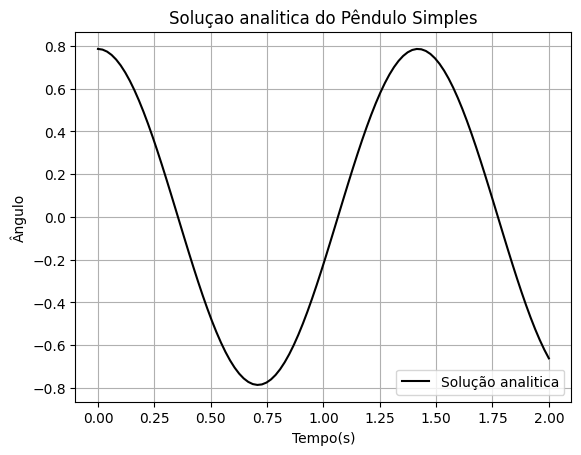

In [5]:
# Criando os dados de treino
t_train = tc.linspace( t_i, t_f, 100, requires_grad = True).reshape(-1,1) # Tempo. 
theta_train = soluçao_analitivca_OHM( x_0 = x_0, omega_0 = Omega_0 , t = t_train) # Solução analitivca do OHS.

icx = tc.tensor([x_0] ) # Condiçao inicial da posição.
icv = tc.tensor([0])    # Condiçao inicial da velocidade.

model = Rede_Neural(neuronio = 10,M=2,output=1, activation=SineActivation()) # Definindo a rede neural 
opt = tc.optim.Adam(params=model.parameters(),lr=0.0051)  # definindo o otimizador 


plt.plot(t_train.detach().numpy(), theta_train.detach().numpy(),"k-", label="Solução analitica")

# Adicionando rótulos e título
plt.ylabel("Ângulo")
plt.xlabel("Tempo(s)")
plt.title("Soluçao analitica do Pêndulo Simples")
plt.legend()
plt.grid(True)
plt.show()

### Treinando nossa rede

Vamos treinar a rede usando autogradentes do PyTorch. Isto é, não calculamos analiticamente as derivadas, mas obtemo-as por meio de diferenciação automática (uma técnica simbólica da rede). Veja a parte do código entre as cerquilhas. Estamos simplesmente pedindo para que as derivadas encontradas respeitem a equação diferencial e os parâmetros dados. Já que a própria EDO é tal que é igual a 0, então podemos quadrá-la para obter uma função custo convexa e minimizá-la.

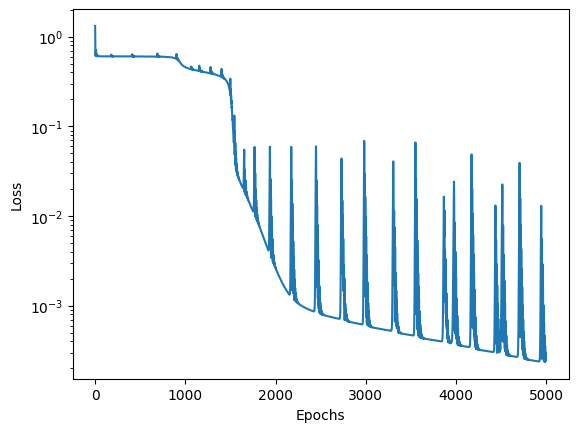

In [6]:
LOSS = []
for epoch in range(5000):
    y_preds = model(t_train)
    solution_theta = y_preds.reshape(-1,1)

    ###########################################################################
    d_theta_dt = tc.autograd.grad(solution_theta,
                                    t_train, 
                                    grad_outputs = tc.ones_like(solution_theta),
                                    create_graph = True)[0]
    d_omega_dt = tc.autograd.grad(d_theta_dt,
                                    t_train, 
                                    grad_outputs = tc.ones_like(d_theta_dt),
                                    create_graph=True)[0]

    # Edo
    loss_ode_dvdt = tc.mean( (d_omega_dt + Omega_0**2*solution_theta )**2 )

    # Condição inicial para x0
    loss_icx = (solution_theta[0] - icx)**2

    # Condição inicial para v0
    loss_icv = (d_theta_dt[0] - icv)**2 

    loss = loss_ode_dvdt +loss_icx + loss_icv
    ############################################################################

    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()
    
    LOSS.append(loss.cpu().detach().numpy())

plt.plot(LOSS)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()


Agora iremos comparar a solução da rede neural com a analitica 

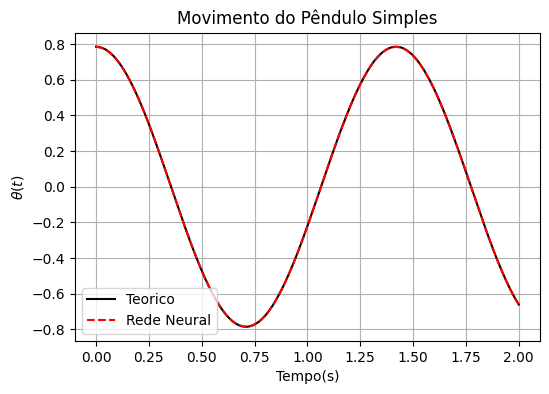

In [7]:
t_test = tc.linspace(t_i,t_f,200,requires_grad=True).reshape(-1,1)
y_test = soluçao_analitivca_OHM(x_0 = x_0 ,omega_0 = Omega_0 ,t = t_test)

y_preds_test = model(t_test)
solution_x = y_preds_test.reshape(-1,1)

plt.subplots(figsize=(6,4))
plt.plot(t_test.detach().numpy(), y_test.detach().numpy(),"k-", label="Teorico")
plt.plot(t_test.detach().numpy(), solution_x.detach().numpy(),"r--", label=f"Rede Neural" )

plt.legend()

# Adicionando rótulos e título
plt.ylabel(r"$\theta(t)$")
plt.xlabel("Tempo(s)")
plt.title("Movimento do Pêndulo Simples")
plt.legend()
plt.grid(True)
plt.show()
plt.show()

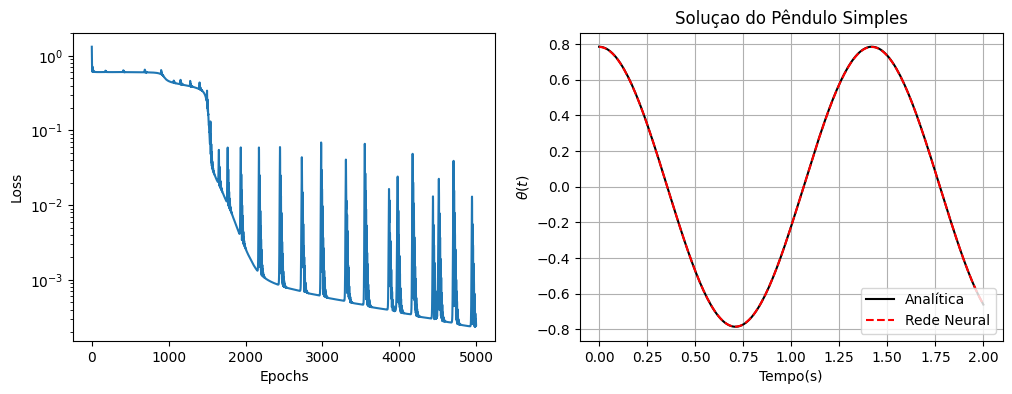

In [10]:
# Definindo o tamanho da figura (largura, altura) em polegadas
plt.figure(figsize=(12, 4))  # Aumente os valores conforme necessário

plt.subplot(1,2,1)
plt.plot(LOSS)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epochs")

plt.subplot(1,2,2)

t_test = tc.linspace(t_i,t_f,200,requires_grad=True).reshape(-1,1)
y_test = soluçao_analitivca_OHM(x_0 = x_0 ,omega_0 = Omega_0 ,t = t_test)

y_preds_test = model(t_test)
solution_x = y_preds_test.reshape(-1,1)
plt.plot(t_test.detach().numpy(), y_test.detach().numpy(),"k-", label="Analítica")
plt.plot(t_test.detach().numpy(), solution_x.detach().numpy(),"r--", label=f"Rede Neural" )



# Adicionando rótulos e título
plt.ylabel(r"$\theta(t)$")
plt.xlabel("Tempo(s)")
plt.title("Soluçao do Pêndulo Simples")
plt.legend()
plt.grid()
plt.show()